In [16]:
import pandas as pd
import matplotlib as plt
import numpy as np

### Read the dataset about health and filter it by USA

In [17]:
df = pd.read_csv("PLACES_Local_Data_for_Better_Health_County_Data_2022_release_20250320.csv")

df = df[df["Data_Value_Type"].str.contains("Crude", na=False)]


# Rename the city column
df = df.rename(columns={"LocationName": "city"})


# Drop unnecessary columns
df = df.drop(['StateAbbr', 'StateDesc', 'DataSource', 'Category', 'LocationID', 'CategoryID', 'DataValueTypeID', 'Geolocation', 'TotalPopulation', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'Data_Value_Footnote_Symbol', 'MeasureId', 'Data_Value_Footnote' ], axis=1)
# First, let's identify the unique cities and measures
unique_cities = df['city'].unique()
unique_measures = df['Short_Question_Text'].unique()

print(f"Number of unique cities: {len(unique_cities)}")
print(f"Number of unique measures: {len(unique_measures)}")

# Create a pivot table with cities as index and measures as columns
new_df = df.pivot_table(
    index='city',
    columns='Measure',
    values='Data_Value',
    aggfunc='mean'  # Use mean if there are duplicate entries
)

# Reset the index to make 'city' a column again
new_df = new_df.reset_index()

new_df = new_df.drop(['Current lack of health insurance among adults aged 18-64 years',
'Cervical cancer screening among adult women aged 21-65 years',
'Visits to dentist or dental clinic among adults aged >=18 years',
 'Visits to doctor for routine checkup within the past year among adults aged >=18 years',
 'Mammography use among women aged 50-74 years',
 'Cholesterol screening among adults aged >=18 years',
 'Older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening',
 'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years',
 'Older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years',
], axis=1)

# All diseases
# list(df['Measure'].unique())


df.head()



Number of unique cities: 1841
Number of unique measures: 30


,Year,city,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,Short_Question_Text
0,2020,NaN,Current lack of health insurance among adults ...,%,Crude prevalence,15.3,Health Insurance
1,2020,Talladega,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,15.1,Diabetes
2,2020,Tallapoosa,Diagnosed diabetes among adults aged >=18 years,%,Crude prevalence,16.0,Diabetes
4,2020,Aleutians East,Cervical cancer screening among adult women ag...,%,Crude prevalence,68.3,Cervical Cancer Screening
5,2020,Anchorage,Depression among adults aged >=18 years,%,Crude prevalence,16.5,Depression


### Read the air quality dataset and clean the data

In [18]:
airdf = pd.read_excel("who_ambient_air_quality_database_version_2024_(v6.1).xlsx", sheet_name="Update 2024 (V6.1)")


# Filter by US
airdf = airdf[airdf["country_name"] == "United States of America"]

# Drop unnnecessary columns
airdf = airdf.drop(['country_name', 'version','reference','web_link', 'population_source','who_ms', 'type_of_stations', 'population', 'latitude', 'longitude', 'iso3', 'who_region', 'pm25_tempcov', 'pm10_tempcov','no2_tempcov'], axis=1)

# Remove state from city names
airdf['city'] = airdf['city'].str.split(' ').str[0]

# Leave only year 2020
airdf = airdf[airdf['year'] == 2019.0]


### Merge the datasets

In [19]:
merged_df = pd.merge(new_df, airdf, on='city', how='inner')
merged_df = merged_df.drop_duplicates(subset='city', keep='first')
merged_df 

,city,All teeth lost among adults aged >=65 years,Arthritis among adults aged >=18 years,Binge drinking among adults aged >=18 years,Cancer (excluding skin cancer) among adults aged >=18 years,Chronic kidney disease among adults aged >=18 years,Chronic obstructive pulmonary disease among adults aged >=18 years,Coronary heart disease among adults aged >=18 years,Current asthma among adults aged >=18 years,Current smoking among adults aged >=18 years,...,No leisure-time physical activity among adults aged >=18 years,Obesity among adults aged >=18 years,Physical health not good for >=14 days among adults aged >=18 years,Sleeping less than 7 hours among adults aged >=18 years,Stroke among adults aged >=18 years,Taking medicine for high blood pressure control among adults aged >=18 years with high blood pressure,year,pm10_concentration,pm25_concentration,no2_concentration
0,Albany,9.35,19.40,18.75,5.85,2.50,5.35,5.15,10.10,13.35,...,19.40,25.45,7.95,30.60,2.40,72.35,2019.0,NaN,9.30,NaN
2,Alexandria,6.20,19.50,16.30,5.60,2.30,4.00,4.30,8.80,11.60,...,17.60,28.00,7.10,34.40,2.20,72.10,2019.0,NaN,7.50,NaN
3,Anchorage,9.50,20.30,20.00,5.70,2.40,4.60,4.90,9.20,15.70,...,19.30,28.50,8.30,30.90,2.50,64.00,2019.0,14.325,7.35,NaN
4,Athens,14.70,26.00,18.00,5.60,2.90,9.30,7.00,11.60,23.00,...,26.50,36.60,11.10,35.80,3.10,71.60,2019.0,NaN,9.80,NaN
6,Atlantic,10.50,26.30,14.10,7.20,3.20,7.20,7.60,10.10,15.90,...,23.50,32.20,10.50,33.30,3.50,NaN,2019.0,NaN,6.60,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,Worcester,9.40,29.75,14.55,8.25,3.20,6.90,7.35,9.95,14.35,...,23.85,30.85,9.35,30.80,3.30,78.10,2019.0,12.700,8.00,19.7
120,Yakima,13.50,24.20,13.80,6.00,3.50,7.50,7.10,11.20,17.00,...,25.50,36.60,12.90,31.10,3.60,66.40,2019.0,NaN,9.20,NaN
121,York,9.32,27.62,16.82,7.46,2.88,6.62,6.66,9.44,15.68,...,21.82,33.36,9.24,31.56,2.98,76.24,2019.0,NaN,8.80,13.8
122,Yuba,11.70,23.20,18.10,5.90,3.00,7.30,6.30,10.50,15.20,...,23.80,33.80,11.60,34.40,3.10,68.40,2019.0,NaN,8.40,12.2


Merged dataframe columns: ['city', 'All teeth lost among adults aged >=65 years', 'Arthritis among adults aged >=18 years', 'Binge drinking among adults aged >=18 years', 'Cancer (excluding skin cancer) among adults aged >=18 years', 'Chronic kidney disease among adults aged >=18 years', 'Chronic obstructive pulmonary disease among adults aged >=18 years', 'Coronary heart disease among adults aged >=18 years', 'Current asthma among adults aged >=18 years', 'Current smoking among adults aged >=18 years', 'Depression among adults aged >=18 years', 'Diagnosed diabetes among adults aged >=18 years', 'Fair or poor self-rated health status among adults aged >=18 years', 'High blood pressure among adults aged >=18 years', 'High cholesterol among adults aged >=18 years who have been screened in the past 5 years', 'Mental health not good for >=14 days among adults aged >=18 years', 'No leisure-time physical activity among adults aged >=18 years', 'Obesity among adults aged >=18 years', 'Physica

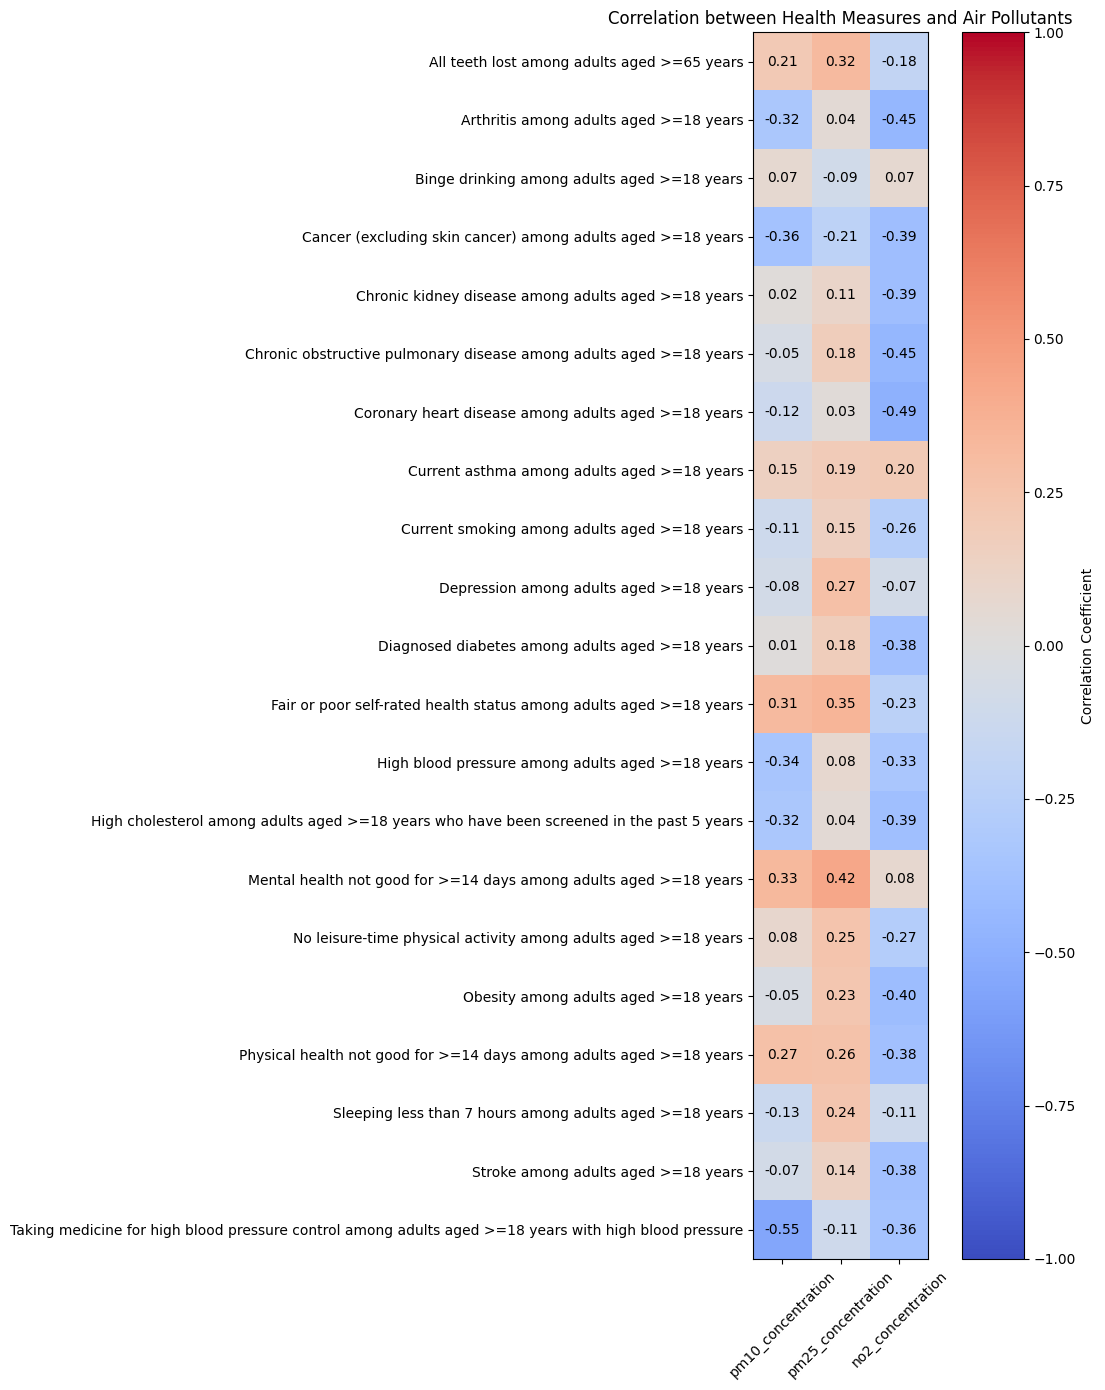

In [20]:
# Print all column names to identify the correct ones
print("Merged dataframe columns:", merged_df.columns.tolist())

# Update these with the ACTUAL column names from your print output
pollutants = ['pm10_concentration', 'pm25_concentration', 'no2_concentration']  # Use the correct names

# Get disease columns
disease_columns = [col for col in new_df.columns if col != 'city']

# Create a correlation matrix between pollutants and diseases
correlation_matrix = merged_df[pollutants + disease_columns].corr()

# Extract and transpose the correlation matrix - diseases as rows and pollutants as columns
disease_pollutant_corr = correlation_matrix.loc[disease_columns, pollutants]

# Display the correlation matrix
print("Correlation between health measures and air pollutants:")
disease_pollutant_corr

# Visualize the correlation matrix as a heatmap using matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 14))  # Adjusted for more rows than columns
im = plt.imshow(disease_pollutant_corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Correlation Coefficient')

# Add labels and title
plt.title('Correlation between Health Measures and Air Pollutants')
plt.xticks(np.arange(len(pollutants)), pollutants, rotation=45)
plt.yticks(np.arange(len(disease_columns)), disease_columns)

# Add correlation values as text annotations
for i in range(len(disease_columns)):
    for j in range(len(pollutants)):
        text = plt.text(j, i, f'{disease_pollutant_corr.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black")

plt.tight_layout()
plt.savefig('corr.png')
plt.show()

['Albany', 'Alexandria', 'Anchorage', 'Athens', 'Atlantic', 'Augusta', 'Austin', 'Baltimore', 'Bay', 'Beaver', 'Bennington', 'Boise', 'Boulder', 'Brunswick', 'Buffalo', 'Burlington', 'Butte', 'Cedar', 'Charleston', 'Charlotte', 'Charlottesville', 'Cheyenne', 'Cleveland', 'Clinton', 'Colorado', 'Columbia', 'Columbus', 'Dallas', 'Decatur', 'Denver', 'Dickinson', 'Dodge', 'Durham', 'Elkhart', 'Elko', 'Erie', 'Eureka', 'Florence', 'Fresno', 'Gadsden', 'Georgetown', 'Grand', 'Greeley', 'Green', 'Greenville', 'Harrisonburg', 'Hartford', 'Hickory', 'Houston', 'Huntington', 'Iowa', 'Jackson', 'Jasper', 'Juneau', 'Kalamazoo', 'Klamath', 'Lafayette', 'Lake', 'Lancaster', 'Laramie', 'Lebanon', 'Lexington', 'Lincoln', 'Lynchburg', 'Macon', 'Madera', 'Madison', 'Marshall', 'Mason', 'Merced', 'Miami', 'Milwaukee', 'Missoula', 'Mobile', 'Monroe', 'Montgomery', 'Muscatine', 'Muskogee', 'Oklahoma', 'Philadelphia', 'Portsmouth', 'Price', 'Providence', 'Pueblo', 'Raleigh', 'Reno', 'Richmond', 'Riverside'

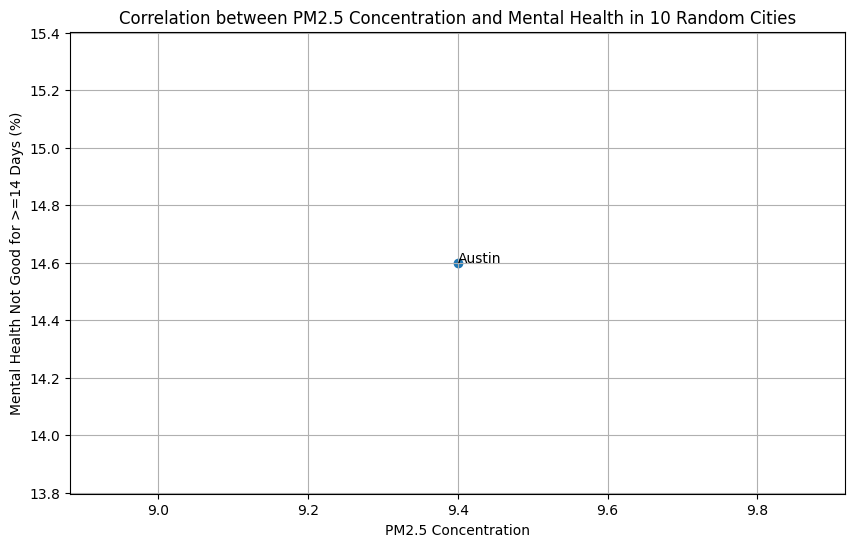

In [ ]:
import random

# Select 10 random cities
# random_cities = list(merged_df['city'].unique())

random_cities = ["Austin"]


# Filter the dataframe for these cities
filtered_df = merged_df[merged_df['city'].isin(random_cities)]

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['pm25_concentration'], filtered_df['Mental health not good for >=14 days among adults aged >=18 years'])

# Add labels and title
plt.xlabel('PM2.5 Concentration')
plt.ylabel('Mental Health Not Good for >=14 Days (%)')
plt.title('Correlation between PM2.5 Concentration and Mental Health in 10 Random Cities')

# Annotate the points with city names
for i, row in filtered_df.iterrows():
    plt.annotate(row['city'], (row['pm25_concentration'], row['Mental health not good for >=14 days among adults aged >=18 years']))

plt.grid(True)
plt.show()